<a href="https://colab.research.google.com/github/aekaba/Customer-Churn-Prediction-with-AI/blob/main/CustomerChurnAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abonelik Sistemlerinde Müşteri Kaybı Analizi



## Dosya Okuma
  datasetimizi drive a kaydetip oradan okuma yapacağız, Train ve Test olarak 2 tane sınıfımız olduğu için bunları birleştireceğiz.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Read CSV files into dataframes
dfTesting = pd.read_csv('/content/drive/MyDrive/Customer Churn Dataset/customer_churn_dataset-testing-master.csv')
dfTraining = pd.read_csv('/content/drive/MyDrive/Customer Churn Dataset/customer_churn_dataset-training-master.csv')

mergedDF = pd.merge(dfTesting, dfTraining, how='outer')

df = pd.DataFrame(mergedDF)

<ipython-input-2-6df33b7f807d>:7: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  mergedDF = pd.merge(dfTesting, dfTraining, how='outer')


In [3]:
print("Toplam Satır Sayısı: ",len(df))
df.head()

Toplam Satır Sayısı:  505207


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1.0,22.0,Female,25.0,14.0,4.0,27.0,Basic,Monthly,598.0,9.0,1.0
1,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
2,2.0,41.0,Female,28.0,28.0,7.0,13.0,Standard,Monthly,584.0,20.0,0.0
3,3.0,47.0,Male,27.0,10.0,2.0,29.0,Premium,Annual,757.0,21.0,0.0
4,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0


##Veri Keşfi
Eksik verilerimizin ne kadar ve nerede olduğunu gördük. Veri Seti elemanlarının dağılımlarının eşit olduğunu gördük. Isı haritası ile veri setimizdeki değişkenlerin korelasyonlarını görselleştirdik. Modelin performansı için CustomerID sütunu silinecektir. Chrun ile doğru ilişkide olan support calls (0.52) ve payment delay (0.33) görülmüştür. Ters ilişkide ise total spend (-0.37) dikkat çekmiştir. Yaş arttıkça churn ihtimalide (0.19) artmaktadır ama bu düşük bir değer.


In [4]:
missing_values = df.isnull().sum()
print(missing_values)
df.info()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last In

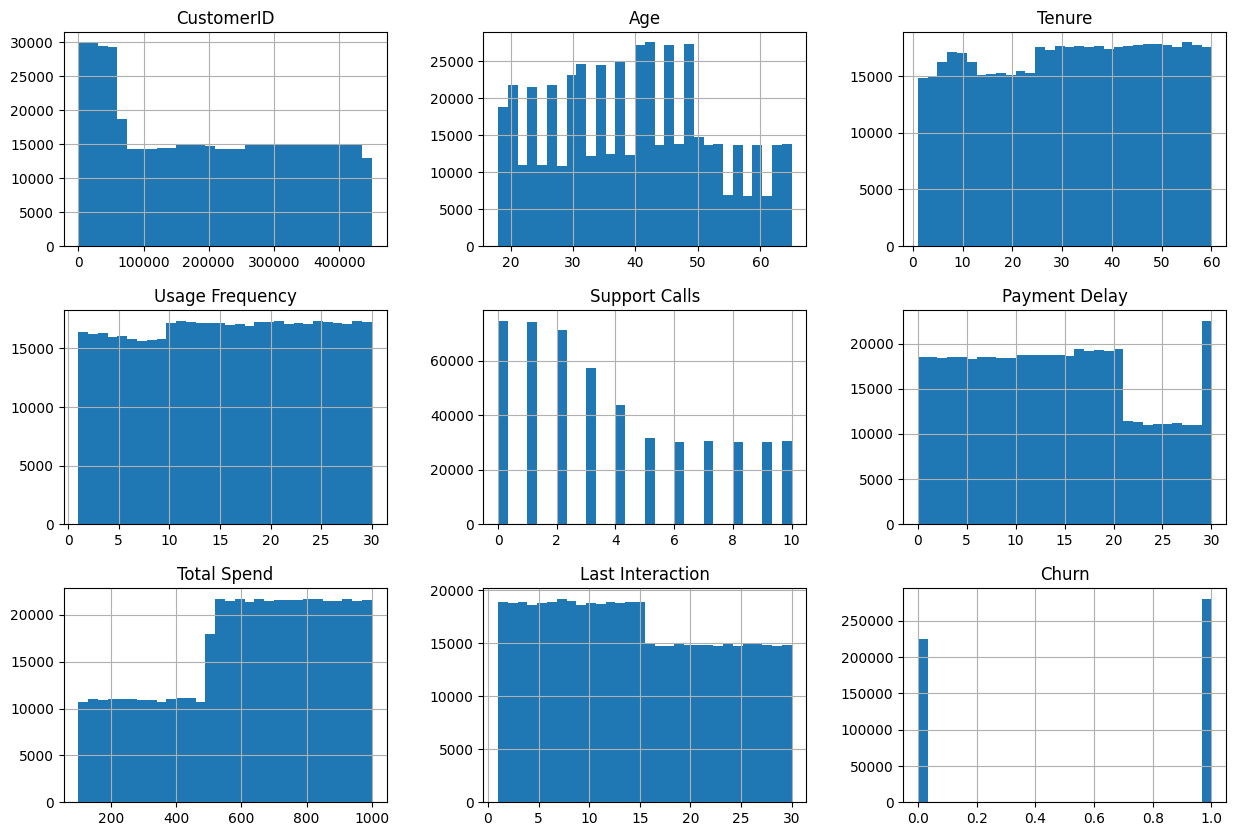

In [5]:
import matplotlib.pyplot as plt
df.hist(bins=30, figsize=(15, 10))
plt.show()

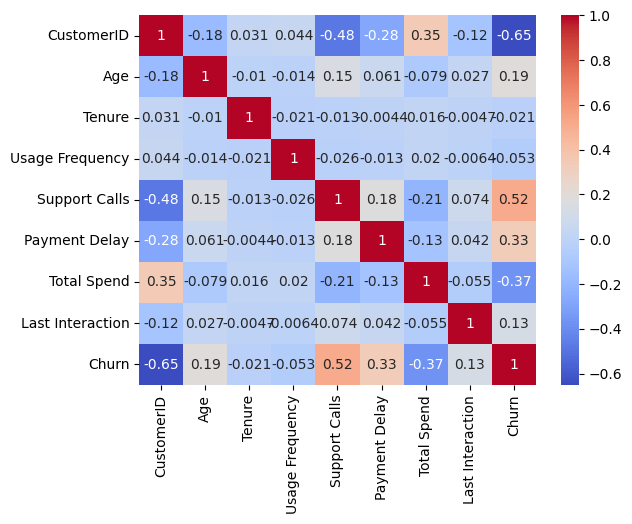

In [6]:
import seaborn as sns
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

##Veri Ön İşleme
Bu kısımda eksik veriler sütunun ortalaması ile doldurulacak, aykırı değerler z-skoru yöntemi ile tespit edilip temizlenecek. Gerekli sütunlar min-max scaler ile ölçeklemesi gerçekleştirilecek. ve customerID çıkarılacak. Veri ayırma işlemi %90 eğitim %10 test verisi olarak gerçekleştirilecektir.    


In [7]:
df=df.drop(columns=['CustomerID'])

### Eksik Verileri Doldurma
Burada sadedce int değerlerin ortalamasını girebileceğimiz için onları seçmemiz gerekir


In [8]:
import numpy as np
print("Eksik değerlerin sayısı:\n", df.isnull().sum())

numeric_df = df.select_dtypes(include=np.number)

df[numeric_df.columns] = df[numeric_df.columns].fillna(numeric_df.mean())
print("Eksik değerler dolduruldu.")

Eksik değerlerin sayısı:
 Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64
Eksik değerler dolduruldu.


Burada Gender, subscription type ve contract lenght bir integer değer olmadığı için onlarda eksik değer bulunan satırlar ortalaması farklı şekilde alınıp kullanıldı.

In [9]:
categorical_columns = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-9-65c94d3875e3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


### Aykırı verilerin Tespiti ve temizlenmesi
Z-Scoru Yöntemi ile aykırı veriler temizlenmiştir.

In [10]:
from scipy.stats import zscore

# Z-Skoru hesaplama
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
threshold = 2 # Aykırı değer eşiği
sd = df[(z_scores < threshold).all(axis=1)]
print(f"Aykırı değerler temizlendi. Yeni veri seti boyutu: {sd.shape}")

df_cleaned = sd


Aykırı değerler temizlendi. Yeni veri seti boyutu: (494576, 11)


### Kategorik Verilerin Sayısal Hale Dönüştürülmesi
Burada Gender, Contract Lenght ve subscription Type Label encoding kullanılarak etikelenmiştir.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Gender için Label Encoding
le_gender = LabelEncoder()
df_cleaned['Gender'] = le_gender.fit_transform(df_cleaned['Gender'])

# Contract Length için Label Encoding
le_contract = LabelEncoder()
df_cleaned['Contract Length'] = le_contract.fit_transform(df_cleaned['Contract Length'])

# Subscription Type için Label Encoding
le_subscription = LabelEncoder()
df_cleaned['Subscription Type'] = le_contract.fit_transform(df_cleaned['Subscription Type'])

print(df_cleaned.head())


    Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  22.0       0    25.0             14.0            4.0           27.0   
1  30.0       0    39.0             14.0            5.0           18.0   
2  41.0       0    28.0             28.0            7.0           13.0   
3  47.0       1    27.0             10.0            2.0           29.0   
4  65.0       0    49.0              1.0           10.0            8.0   

   Subscription Type  Contract Length  Total Spend  Last Interaction  Churn  
0                  0                1        598.0               9.0    1.0  
1                  2                0        932.0              17.0    1.0  
2                  2                1        584.0              20.0    0.0  
3                  1                0        757.0              21.0    0.0  
4                  0                1        557.0               6.0    1.0  


<ipython-input-11-f8df42723aa8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Gender'] = le_gender.fit_transform(df_cleaned['Gender'])
<ipython-input-11-f8df42723aa8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Contract Length'] = le_contract.fit_transform(df_cleaned['Contract Length'])
<ipython-input-11-f8df42723aa8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

### Veri Ölçekleme
Min-Max Slacer kullanılarak yapılacaktır. Age, Usage Frequency, Support Calls, Payment Delay, Total Spend, Last Interaction, kısımlarına uygulanmıştır.

In [12]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = ['Age', 'Usage Frequency', 'Support Calls', 'Payment Delay',
                     'Total Spend', 'Last Interaction']
scaler = MinMaxScaler()

df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

print(df_cleaned.head())


        Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  0.085106       0    25.0         0.448276            0.4       0.900000   
1  0.255319       0    39.0         0.448276            0.5       0.600000   
2  0.489362       0    28.0         0.931034            0.7       0.433333   
3  0.617021       1    27.0         0.310345            0.2       0.966667   
4  1.000000       0    49.0         0.000000            1.0       0.266667   

   Subscription Type  Contract Length  Total Spend  Last Interaction  Churn  
0                  0                1     0.538228          0.275862    1.0  
1                  2                0     0.921889          0.551724    1.0  
2                  2                1     0.522147          0.655172    0.0  
3                  1                0     0.720869          0.689655    0.0  
4                  0                1     0.491132          0.172414    1.0  


<ipython-input-12-b8e68cefe814>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])


### Veri Ayırma
Burada verisetimiz işlenmiş olarak test ve eğitim verisi olarak 2 ayrı dataframe e ayrılacaktır. Başta %90 eğitim verisi %10 test verisi olarak ayrılacaktır. Eğer bu değerler yeterli olmazsa ileride değişiklik yapılacaktır.

In [13]:
from sklearn.model_selection import train_test_split

# Özellikler (X) ve hedef değişken (y) belirleme
data_set_attributes = df_cleaned.drop(columns=['Churn'])  # Churn hedef sütunu
data_set_classes = df_cleaned['Churn']



# Veri setini ayırma
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")


## Öznitelik Seçimi


In [67]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score, precision_score, balanced_accuracy_score, log_loss
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np


# KFold tanımlama
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def preprocess_features(X_train, X_test, use_pca=False, variance_threshold=0.1):
    # PCA
    if use_pca:
        pca = PCA(n_components=6)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Varyans eşikleme
    else:
      vt = VarianceThreshold(threshold=variance_threshold)
      X_train = vt.fit_transform(X_train)
      X_test = vt.transform(X_test)

    return X_train, X_test


## Confusion matris heatmap çizimi

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_average_confusion_matrix_heatmap(results_df):
    # Ortalama satırını filtrele
    avg_row = results_df[results_df["Fold"] == "Average"]
    if avg_row.empty:
        raise ValueError(f"Ortalama değerleri içeren satır Average bulunamadı.")

    confusion_values = [avg_row["TN"].values[0], avg_row["FP"].values[0],
                        avg_row["FN"].values[0], avg_row["TP"].values[0]]

    # Heatmap çizimi
    cm_matrix = [[confusion_values[0], confusion_values[1]],  # [[TN, FP],
                 [confusion_values[2], confusion_values[3]]]  #  [FN, TP]]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.title("Karmaşıklık Matrisi")
    plt.xlabel("Tahmini Etiketler")
    plt.ylabel("Doğru Etiketler")
    plt.xticks([0.5, 1.5], ["Negatif", "Pozitif"])
    plt.yticks([0.5, 1.5], ["Negatif", "Pozitif"], rotation=0)
    plt.show()



## Makine Öğrenimi Model Eğitimi


In [16]:
import time
def evaluate_model(model, params, X, y, use_pca=False, variance_threshold=0.1,file_name="fold_results"):
    all_folds = []

    for fold_index, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
        print(f"{fold_index}. fold işlemi başladı...")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train, X_test = preprocess_features(X_train, X_test, use_pca=use_pca, variance_threshold=variance_threshold)

        y_train = y_train.astype(int)
        y_test = y_test.astype(int)

        start_time = time.time()
        # Hiperparametre optimizasyonu
        grid = GridSearchCV(model, params, cv=kf, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X_train, y_train)

        training_time = time.time() - start_time

        best_model = grid.best_estimator_
        best_params = grid.best_params_

        y_pred = best_model.predict(X_test)
        y_pred = y_pred.astype(int)

        # Performans metriklerini hesapla
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        try:
             auc = (roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))
        except AttributeError:
             auc =("N/A")
        # Confusion matrix değerlerini hesapla
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = ( tn / (tn+fp))
        logloss = log_loss(y_test, best_model.predict_proba(X_test))
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        all_folds.append({
            "Fold": fold_index,
            "Best Parameters": best_params,
            "Training Time (s)": training_time,
            "Accuracy": accuracy,
            "F1-Score": f1,
            "AUC": auc,
            "Recall": recall,
            "Precision": precision,
            "Specificity": specificity,
            "LogLoss": logloss,
            "Balanced Accuracy": balanced_acc,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp
        })

    averages = pd.DataFrame(all_folds).mean(numeric_only=True).to_dict()
    averages["Fold"] = "Average"
    averages["Best Parameters"] = "N/A"
    all_folds.append(averages)

    results_df = pd.DataFrame(all_folds)
    results_df.to_excel(file_name, index=False)
    plot_average_confusion_matrix_heatmap(results_df)


### Lojistik Regresyon

In [17]:
def Evalute_LogRes():
  logResModel = LogisticRegression()
  logResParams = {
      'C': [0.1, 1, 10],
      'solver': ['lbfgs', 'liblinear']
  }

  evaluate_model(logResModel, logResParams, data_set_attributes, data_set_classes, use_pca=True,file_name="LogResPCAOn.xlsx")
#Evalute_LogRes()

### Decision Tree


In [18]:
def Evalute_DecisionTree():
  DecisionTreeModel = DecisionTreeClassifier()
  DecisionTreeParams = {
      'max_depth': [5, 10, 20, None],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  evaluate_model(DecisionTreeModel, DecisionTreeParams, data_set_attributes, data_set_classes, use_pca=True,file_name="DecisionTreePCAOn.xlsx")
#Evalute_DecisionTree()

### KNN

In [19]:
def Evalute_knn():
  Evalute_knnModel = KNeighborsClassifier()
  knnParams = {
     'n_neighbors': [3, 5, 7, 9],
     'weights': ['uniform', 'distance']
  }

  evaluate_model(Evalute_knnModel, knnParams, data_set_attributes, data_set_classes, use_pca=True,file_name="KNNPCAOn.xlsx")
#Evalute_knn()

### Naive Bayes


In [20]:
def Evalute_naiveBayes():
  NaiveBayesModel = GaussianNB()
  NaiveBayesParams = {}

  evaluate_model(NaiveBayesModel, NaiveBayesParams, data_set_attributes, data_set_classes, use_pca=True,file_name="NaiveBayesPCAOn.xlsx")
#Evalute_naiveBayes()

### Random Forest

In [21]:
def Evalute_RandomForest():
  RandomForestModel = RandomForestClassifier()
  RandomForestParams = {
      'n_estimators': [50, 100],
      'max_depth': [5],
      'min_samples_split': [  10],
      'min_samples_leaf': [  4],
  }

  evaluate_model(RandomForestModel, RandomForestParams, data_set_attributes, data_set_classes, use_pca=True,file_name="RandomForestPCAon.xlsx")
#Evalute_RandomForest()

### Meta Model Eğitimi
Optimizasyon ve pca


In [22]:
from sklearn.ensemble import StackingClassifier
base_models = [
    ('naive_bayes', GaussianNB()),
    ('decision_tree', DecisionTreeClassifier(max_depth=5,min_samples_leaf=1,min_samples_split=2))
]
# Meta model (Random Forest) ve hiperparametreler
meta_model = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_leaf=4,min_samples_split=10)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=kf)

Eğitim


In [23]:
# Performans değerlendirme fonksiyonu
def evaluate_stacking_model(model, X, y, use_pca=False, variance_threshold=0.1,file_name="stacking.xlsx"):
    fold_results = []

    for fold_index, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
        print(f"{fold_index}.fold başladı")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Özellik işleme
        X_train, X_test = preprocess_features(X_train, X_test, use_pca=use_pca, variance_threshold=variance_threshold)

        y_train = y_train.astype(int)
        y_test = y_test.astype(int)
        # Model eğitimi ve tahmin
        start_time = time.time()
        model.fit(X_train, y_train)

        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        y_pred = y_pred.astype(int)

        # Performans metriklerini hesapla
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        try:
             auc = (roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        except AttributeError:
             auc =("N/A")
        # Confusion matrix değerlerini hesapla
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = ( tn / (tn+fp))
        logloss = log_loss(y_test, model.predict_proba(X_test))
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fold_results.append({
            "Fold": fold_index,
            "Training Time (s)": training_time,
            "Accuracy": accuracy,
            "F1-Score": f1,
            "AUC": auc,
            "Recall": recall,
            "Precision": precision,
            "Specificity": specificity,
            "LogLoss": logloss,
            "Balanced Accuracy": balanced_acc,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp
        })

    averages = pd.DataFrame(fold_results).mean(numeric_only=True).to_dict()
    averages["Fold"] = "Average"
    fold_results.append(averages)

    results_df = pd.DataFrame(fold_results)
    results_df.to_excel(file_name, index=False)
    plot_average_confusion_matrix_heatmap(results_df)


çalıştırma

In [24]:
#evaluate_stacking_model(stacking_clf, data_set_attributes, data_set_classes, use_pca=True,file_name="StackingEnsemblePCAOn.xlsx")

## Derin Öğrenme Modelleri


### Grafik Çizim


In [28]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Kesinliği')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Kesinliği')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('İterasyon')
    plt.ylabel('Kesinlik')
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
def evaluate_dl_model(build_model_fn,X,y,use_pca=False, variance_threshold=0.1,file_name="dl_results.xlsx",epochs=20, batch_size=64, patience=3):
  fold_results = []

  for fold_index, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    print(f"{fold_index}.fold başladı")

    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    X_train, X_test = preprocess_features(X_train, X_test, use_pca=use_pca, variance_threshold=variance_threshold)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    start_time = time.time()

    model = build_model_fn(X_train.shape[1])

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

    training_time = time.time() - start_time

    plot_training_history(history)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    fold_results.append({
            "Fold": fold_index,
            "Time": training_time,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, y_pred_proba),
            "Recall": recall_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Log Loss": log_loss(y_test, y_pred_proba),
            "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp
        })
  averages = pd.DataFrame(fold_results).mean(numeric_only=True).to_dict()
  averages["Fold"] = "Average"
  fold_results.append(averages)

  results_df = pd.DataFrame(fold_results)
  results_df.to_excel(file_name, index=False)
  plot_average_confusion_matrix_heatmap(results_df)

### ANN

1.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


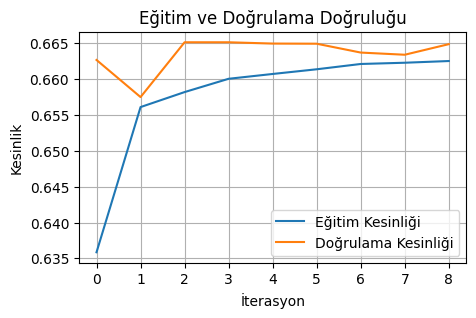

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
2.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


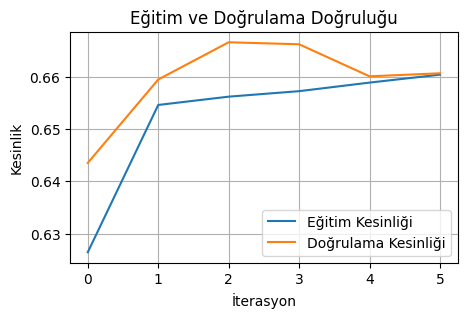

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
3.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


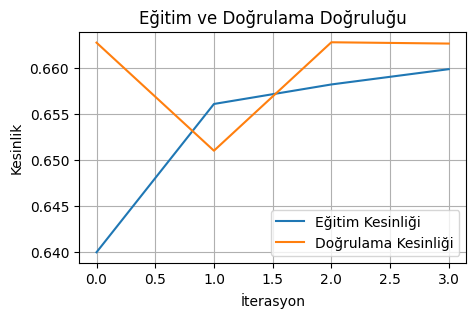

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
4.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


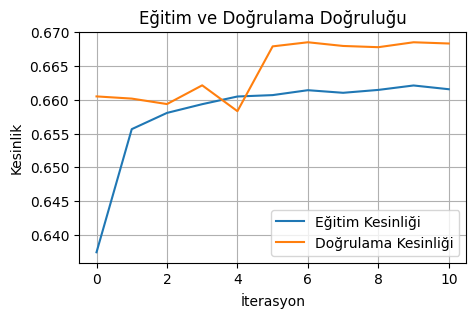

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


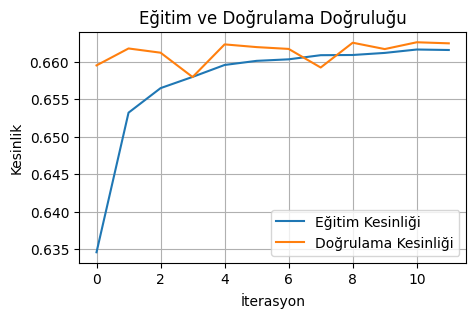

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


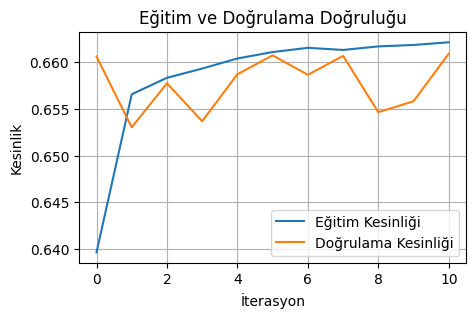

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
7.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


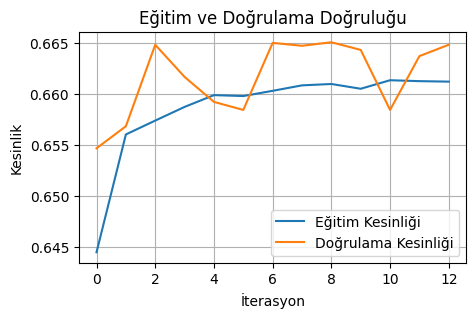

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
8.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


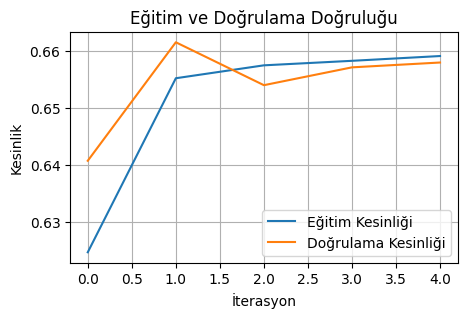

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
9.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


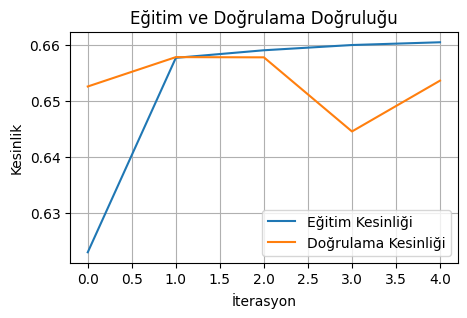

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
10.fold başladı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


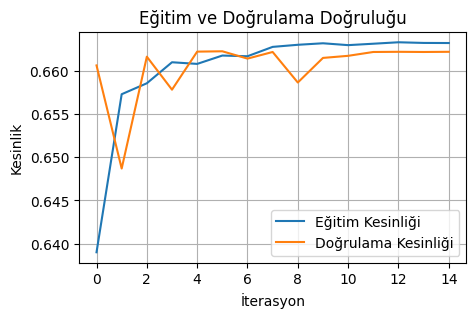

1546/1546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


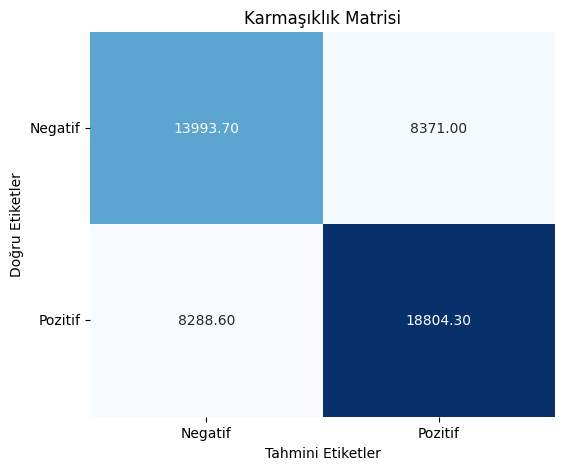

In [27]:
def build_ann(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

evaluate_dl_model(
    build_model_fn=lambda input_dim: build_ann(input_dim),
    X=data_set_attributes,
    y=data_set_classes,
    use_pca=False,
    variance_threshold=0.1,
    epochs=20,
    batch_size=64,
    file_name="ANNPCAOff.xlsx"
)

### CNN

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

'''evaluate_dl_model(
    build_model_fn=lambda input_dim: build_cnn(input_dim),
    X=data_set_attributes,
    y=data_set_classes,
    use_pca=True,
    variance_threshold=0.1,
    epochs=20,
    batch_size=64,
    file_name="CNNPCAOn.xlsx"
)'''

'evaluate_dl_model(\n    build_model_fn=lambda input_dim: build_cnn(input_dim),\n    X=data_set_attributes,\n    y=data_set_classes,\n    use_pca=True,  \n    variance_threshold=0.1,\n    epochs=20,\n    batch_size=64,\n    file_name="CNNPCAOn.xlsx"\n)'

### LSTM

In [57]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Veriyi LSTM için yeniden şekillendirme
X_reshaped = data_set_attributes.values.reshape(data_set_attributes.shape[0], 1, data_set_attributes.shape[1])

# LSTM Modeli
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [66]:
evaluate_dl_model(
    build_model_fn=lambda input_dim: build_lstm(input_dim),
    X=X_reshaped,  # Yeniden şekillendirilmiş veri
    y=data_set_classes,
    use_pca=True,
    variance_threshold=0.1,
    epochs=20,
    batch_size=64,
    file_name="LSTMPCAOn.xlsx"
)

1.fold başladı


ValueError: Found array with dim 3. PCA expected <= 2.